In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
cpu


In [ ]:
def preprocess_text(txt):
    # Почему-то при параллельном запуске переменные из вне не видны
    import re
    from string import punctuation
    from stop_words import get_stop_words
    sw = set(get_stop_words("en"))
    puncts= set(punctuation)

    from pymorphy2 import MorphAnalyzer
    morpher = MorphAnalyzer()

    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [2]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [132]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.dro = nn.Dropout(0.25)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.dro(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.dro(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [4]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [5]:
TRAIN_FILEPATH = Path('./inputs/Twitter Sentiment Analysis/train.csv')

df = pd.read_csv(TRAIN_FILEPATH)

df_train, df_val = train_test_split(df, random_state=42, test_size=0.3)
df_train.shape, df_val.shape

((22373, 3), (9589, 3))

In [6]:
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [7]:
df_train['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [11]:
# tqdm.pandas()
#
# df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
# df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

In [12]:
%%time
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].parallel_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].parallel_apply(preprocess_text)

Wall time: 25min 47s


In [13]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [88]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alexidis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['summer', 'timeð\x9f\x8c', 'summeriscoming', 'swimming', 'picoftheday']

In [133]:
max_words = 4000
max_len = 10
num_classes = 1
embedding_dim = 128
out_channel = 128

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [134]:
# Отфильтруем данные и соберём в корпус N наиболее частых токенов
tokens_filtered = [word for word in tokens if word.isalnum()]

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

3999

In [135]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [136]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

In [137]:
x_train.shape

(22373, 10)

In [138]:
df_train['tweet'].iloc[0]

'summer timeð\x9f\x8c summeriscoming swimming picoftheday tattoos issho pulsera fluyendo â\x80¦'

In [139]:
x_train[0]

array([  38, 1100,  573,    0,    0,    0,    0,    0,    0,    0])

In [140]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [141]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [142]:
model = Net(vocab_size=max_words, embedding_dim=embedding_dim, out_channel=out_channel, num_classes=num_classes)

In [143]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(4000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (dro): Dropout(p=0.25, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 602497


In [144]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [145]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/5]. Step [44/44]. Loss: 0.179. Acc: 0.925. Test loss: 0.028. Test acc: 0.929
Epoch [2/5]. Step [44/44]. Loss: 0.109. Acc: 0.941. Test loss: 0.041. Test acc: 0.943
Epoch [3/5]. Step [44/44]. Loss: 0.099. Acc: 0.965. Test loss: 0.020. Test acc: 0.943
Epoch [4/5]. Step [44/44]. Loss: 0.083. Acc: 0.973. Test loss: 0.005. Test acc: 0.945
Epoch [5/5]. Step [44/44]. Loss: 0.043. Acc: 0.982. Test loss: 0.001. Test acc: 0.939
Training is finished!


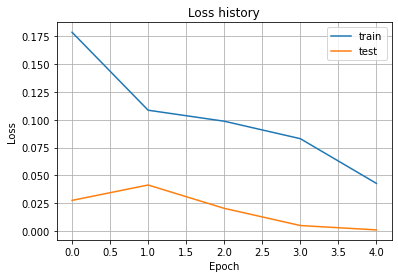

In [146]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите, какой результат вы получили?
Что помогло вам улучшить ее точность?

## Вывод
Добавил слои с dropout что бы снизить переобучение увеличил количество слов в выборке уменьшил количество слов выбираемых из твита для обучения